In [221]:
!pip install numpy pandas matplotlib scikit-learn spacy


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [222]:
# !python -m spacy download en_core_web_sm

In [223]:
# Import necessary libraries
import numpy as np
import pandas as pd
import spacy
import re
import os
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

In [224]:
%matplotlib widget

In [225]:
# Load the English NLP model from spaCy
# nlp = spacy.load("en_core_web_sm")

In [226]:
# Read usernames from a CSV file with a header
filename = "Datasets\\Exposure Management - Accounts [4122_discover_accounts_2023-08-15T07_58_59Z].csv"
df = pd.read_csv(filename, usecols=["Username"]).drop_duplicates()

In [227]:
# Function to count the number of special characters in a username
def count_special_characters(username):
    special_characters = re.findall(r'[!\"#\$%&\'\(\)\*\+,\-\.\/:;<=>\?@\[\\\]\^_`{\|}~]', username)
    return len(special_characters)

# Function to get a list of unique special characters in a username
def unique_special_characters(username):
    special_characters = re.findall(r'[!\"#\$%&\'\(\)\*\+,\-\.\/:;<=>\?@\[\\\]\^_`{\|}~]', username)
    return list(set(special_characters))

# Function to count the number of nouns in a username
def count_nouns(username):
    doc = nlp(username)
    nouns = [token.text for token in doc if token.pos_ == "NOUN"]
    return len(nouns)

In [228]:

# Feature Engineering
df['Length'] = df['Username'].apply(len)
df['Special Characters'] = df['Username'].apply(lambda username: int(bool(re.search(r'[!\"#\$%&\'\(\)\*\+,\-\.\/:;<=>\?@\[\\\]\^_`{\|}~]', username))))
df['Number of Special Characters'] = df['Username'].apply(count_special_characters)
df['Unique Special Characters'] = df['Username'].apply(unique_special_characters)
df['Numbers'] = df['Username'].apply(lambda username: int(bool(re.search(r'\d', username))))
df['Characters'] = df['Username'].apply(lambda username: bool(re.search(r'[a-zA-Z]', username)))
df['Uppercase'] = df['Username'].apply(lambda username: any(char.isupper() for char in username))
df['Number of Words'] = df['Username'].apply(lambda username: len(re.findall(r'\w+', username)))
# df['Nouns'] = df['Username'].apply(count_nouns)


unique_chars = df['Username'].apply(unique_special_characters)
all_unique_chars = set(char for sublist in unique_chars for char in sublist)

# Create binary columns for unique special characters
for char in all_unique_chars:
    df[char] = df['Username'].apply(lambda username: int(char in unique_special_characters(username)))

In [229]:
new_df = df
new_df

,Username,Length,Special Characters,Number of Special Characters,Unique Special Characters,Numbers,Characters,Uppercase,Number of Words,_,-,$,.
0,lenovo_tmp_erfoWBRZ,19,1,2,[_],0,True,True,1,1,0,0,0
1,lenovo_tmp_fykqTCGI,19,1,2,[_],0,True,True,1,1,0,0,0
2,lenovo_tmp_hkviSTET,19,1,2,[_],0,True,True,1,1,0,0,0
3,lenovo_tmp_imabYOEA,19,1,2,[_],0,True,True,1,1,0,0,0
4,lenovo_tmp_jxidRXNO,19,1,2,[_],0,True,True,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4116,lenovo_tmp_sxehTMXL,19,1,2,[_],0,True,True,1,1,0,0,0
4117,lenovo_tmp_tcnuICIY,19,1,2,[_],0,True,True,1,1,0,0,0
4118,lenovo_tmp_tllnMKCV,19,1,2,[_],0,True,True,1,1,0,0,0
4119,lenovo_tmp_znvkPSWF,19,1,2,[_],0,True,True,1,1,0,0,0


In [230]:
# Define feature names
all_feature_names = ['Uppercase', 'Characters', 'Special Characters', 'Numbers', 'Number of Words', 'Number of Special Characters'] + list(all_unique_chars)

In [231]:

# Normalize and scale features
scaler = StandardScaler()
# scaled_features = scaler.fit_transform(df[['Length', 'Special Characters', 'Numbers', 'Uppercase Letters', 'Number of Words', 'Nouns', 'Number of Special Characters'] + list(all_unique_chars)])
scaled_features = scaler.fit_transform(new_df[all_feature_names])


In [232]:

# Calculate cosine similarity matrix (since we have text-based features)
cosine_sim = cosine_similarity(scaled_features)


In [233]:

# Perform hierarchical clustering
linkage_matrix = linkage(cosine_sim, method='average', metric='cosine')


C:\Users\XFIR-Sense\AppData\Local\Temp\ipykernel_24892\3091788239.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


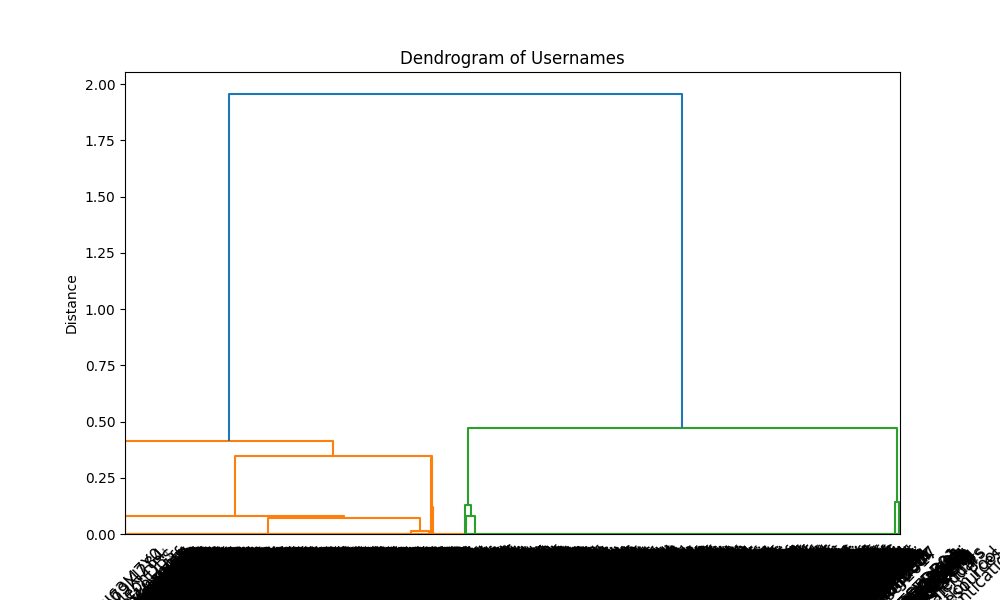

In [234]:
# Visualize the dendrogram (same as before)
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix, labels=new_df['Username'].tolist(), leaf_rotation=45, leaf_font_size=12)
plt.xlabel('Usernames')
plt.ylabel('Distance')
plt.title('Dendrogram of Usernames')
plt.show()


In [235]:
# Range of cluster numbers to iterate through
min_clusters = 2
max_clusters = 50

best_silhouette_score = -1
best_num_clusters = -1
best_cluster_labels = None

silhouette_scores = []

# Iterate through different numbers of clusters
for num_clusters in range(min_clusters, max_clusters + 1):
    # Cut the dendrogram to get clusters
    clusters = fcluster(linkage_matrix, t=num_clusters, criterion='maxclust')

    # Calculate silhouette score
    silhouette_avg = silhouette_score(scaled_features, clusters)

    # Store the silhouette score
    silhouette_scores.append(silhouette_avg)
    
    print(f"Number of Clusters: {num_clusters} - Silhouette Score: {silhouette_avg}")

    # Update best silhouette score and number of clusters if needed
    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        best_num_clusters = num_clusters
        best_cluster_labels = clusters

print(f"Best Number of Clusters: {best_num_clusters} - Best Silhouette Score: {best_silhouette_score}")

Number of Clusters: 2 - Silhouette Score: 0.8091374309256035
Number of Clusters: 3 - Silhouette Score: 0.810895651069229
Number of Clusters: 4 - Silhouette Score: 0.8145817268260629
Number of Clusters: 5 - Silhouette Score: 0.9399941639957916
Number of Clusters: 6 - Silhouette Score: 0.9392134100922955
Number of Clusters: 7 - Silhouette Score: 0.9414200639078751
Number of Clusters: 8 - Silhouette Score: 0.944767629918204
Number of Clusters: 9 - Silhouette Score: 0.9503760686556537
Number of Clusters: 10 - Silhouette Score: 0.9528427049815338
Number of Clusters: 11 - Silhouette Score: 0.9642902049388592
Number of Clusters: 12 - Silhouette Score: 0.9941313439000317
Number of Clusters: 13 - Silhouette Score: 0.9927773390116146
Number of Clusters: 14 - Silhouette Score: 0.993190580306203
Number of Clusters: 15 - Silhouette Score: 0.9929832748425861
Number of Clusters: 16 - Silhouette Score: 0.9956179198637396
Number of Clusters: 17 - Silhouette Score: 0.9979323166894319
Number of Clusters:

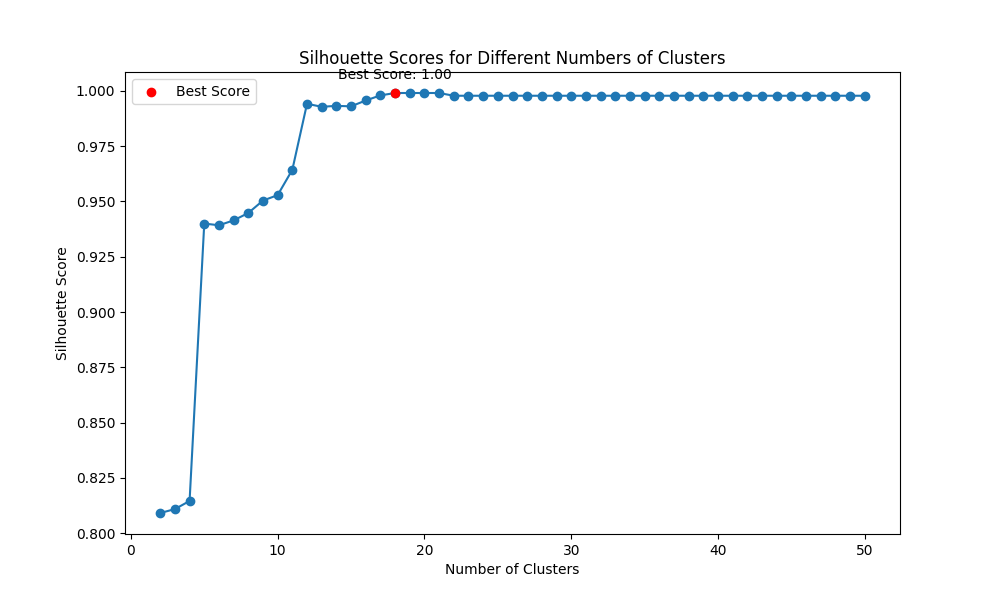

In [236]:
# Plotting the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(min_clusters, max_clusters + 1), silhouette_scores, marker='o')

# Highlight the best silhouette score
plt.scatter(best_num_clusters, best_silhouette_score, color='red', label='Best Score', zorder=5)
plt.annotate(f"Best Score: {best_silhouette_score:.2f}", (best_num_clusters, best_silhouette_score), 
             textcoords="offset points", xytext=(0,10), ha='center')

plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.legend()

plt.show()

In [237]:

# Cut the dendrogram to get clusters (same as before)
num_clusters = best_num_clusters
clusters = fcluster(linkage_matrix, t=num_clusters, criterion='maxclust')
clusters


array([2, 2, 2, ..., 2, 2, 1], dtype=int32)

In [238]:

# Add cluster labels to the DataFrame
new_df['Cluster'] = clusters

# Add a new column "Key Features" to the DataFrame
df['Key Features'] = ''

In [239]:
# Compare mean feature values to identify key features for each cluster
for cluster_label, mean_features in cluster_mean_features.items():
    print(f"Cluster {cluster_label} - Key Features:")
    key_features = []
    for feature_index, mean_value in enumerate(mean_features):
        print(f'\t[-] {all_feature_names[feature_index]} - {mean_value}')
        if feature_index < len(all_feature_names) and mean_value > 1:  # Adjust this threshold based on your data
            key_features.append(all_feature_names[feature_index])

    print(key_features)
    print()

    # Update the "Key Features" column for rows in the current cluster
    cluster_rows = df[df['Cluster'] == cluster_label]
    df.loc[cluster_rows.index, 'Key Features'] = ', '.join(key_features)

Cluster 1 - Key Features:
	[-] Uppercase - 1.1479617118850363
	[-] Characters - 0.0
	[-] Special Characters - 1.132430813451857
	[-] Numbers - 4.3212464326519635
	[-] Number of Words - -0.21499568504699412
	[-] Number of Special Characters - 0.05946237056440132
	[-] _ - 1.238261465638995
	[-] - - -0.20977904626690763
	[-] $ - -0.015748519708717802
	[-] . - -0.03150876360895181
['Uppercase', 'Special Characters', 'Numbers', '_']

Cluster 2 - Key Features:
	[-] Uppercase - 1.1479617118850447
	[-] Characters - 0.0
	[-] Special Characters - 1.1324308134518817
	[-] Numbers - -0.23141471230241129
	[-] Number of Words - -0.21499568504699357
	[-] Number of Special Characters - 0.9378936543967228
	[-] _ - 1.2382614656389743
	[-] - - -0.20977904626690863
	[-] $ - -0.015748519708718055
	[-] . - -0.031508763608952405
['Uppercase', 'Special Characters', '_']

Cluster 3 - Key Features:
	[-] Uppercase - 1.1479617118850363
	[-] Characters - 0.0
	[-] Special Characters - 1.132430813451857
	[-] Numbers 

In [240]:
# # Train a decision tree classifier to predict clusters
# classifier = DecisionTreeClassifier()
# classifier.fit(scaled_features, clusters)  # 'clusters' are the obtained cluster labels


In [241]:
# # Get feature importances
# feature_importances = classifier.feature_importances_

In [242]:
# # Create a dictionary to store the most important features for each cluster
# cluster_most_important_features = {}

# for cluster_label in np.unique(clusters):
#     # Get instances that belong to the current cluster
#     cluster_instances = new_df[clusters == cluster_label]
    
#     # Get the most important features for the current cluster using the trained classifier
#     important_features = new_df.columns[np.argsort(-feature_importances)]
#     most_important_features = important_features[np.isin(important_features, cluster_instances.columns)]
    
#     # Store the most important features in the dictionary
#     cluster_most_important_features[cluster_label] = most_important_features

# # Create a new column in the DataFrame with the most important features for each cluster
# new_df['Most Important Features'] = new_df['Cluster'].map(cluster_most_important_features)


In [243]:
# # Visualize feature importances
# plt.figure(figsize=(10, 6))
# plt.bar(range(len(feature_importances)), feature_importances)
# plt.xticks(range(len(df.columns)), df.columns, rotation='vertical')
# plt.xlabel('Features')
# plt.ylabel('Feature Importance')
# plt.title('Feature Importance Analysis')
# plt.tight_layout()  # Ensure proper spacing of labels
# plt.show()

In [244]:

# Display the clustered usernames (same as before)
print(new_df)

# Get the base filename
base_filename = os.path.basename(filename)

# Remove the extension
filename_without_extension = os.path.splitext(base_filename)[0]

new_df.to_csv(f'output\\clustered_usernames_{filename_without_extension}.csv', index=False)


                 Username  Length  Special Characters  \
0     lenovo_tmp_erfoWBRZ      19                   1   
1     lenovo_tmp_fykqTCGI      19                   1   
2     lenovo_tmp_hkviSTET      19                   1   
3     lenovo_tmp_imabYOEA      19                   1   
4     lenovo_tmp_jxidRXNO      19                   1   
...                   ...     ...                 ...   
4116  lenovo_tmp_sxehTMXL      19                   1   
4117  lenovo_tmp_tcnuICIY      19                   1   
4118  lenovo_tmp_tllnMKCV      19                   1   
4119  lenovo_tmp_znvkPSWF      19                   1   
4120          FF_J63I47Y0      11                   1   

      Number of Special Characters Unique Special Characters  Numbers  \
0                                2                       [_]        0   
1                                2                       [_]        0   
2                                2                       [_]        0   
3                      

In [245]:

# Analyze the patterns within each cluster (same as before)
for cluster_id in range(1, num_clusters + 1):
    cluster_data = new_df[new_df['Cluster'] == cluster_id]
    usernames = cluster_data['Username'].tolist()
    usernames.sort()  # Sort the list of usernames
    print(f"\nCluster {cluster_id} - Usernames: [{len(usernames)}]")
    print(usernames)
    # Additional analysis can be performed on each cluster, such as examining naming conventions.



Cluster 1 - Usernames: [4]
['FF_J63I47Y0', 'FF_b79Xl284', 'MSOL_5cf8f19ab1ff', 'MSOL_740a9fda98e6']

Cluster 2 - Usernames: [1479]
['PAM_BIND_NONPROD', 'PAM_BIND_PROD', 'PAM_FUNCTION_NONPROD', 'PAM_FUNCTION_PROD', 'PAM_SQL_Test', 'SVC_LIMSAZ_DEV', 'lenovo_tmp_aaiuOHGS', 'lenovo_tmp_aamhGSVR', 'lenovo_tmp_aanaRMJB', 'lenovo_tmp_aatrIPAL', 'lenovo_tmp_abezVQTZ', 'lenovo_tmp_acdwKNYX', 'lenovo_tmp_acqdBBGM', 'lenovo_tmp_actqSOBW', 'lenovo_tmp_acuoGJEB', 'lenovo_tmp_adccPIGA', 'lenovo_tmp_adjmDQMN', 'lenovo_tmp_aefdQUAZ', 'lenovo_tmp_afkrETZL', 'lenovo_tmp_aigdMBEW', 'lenovo_tmp_aihbLOBD', 'lenovo_tmp_ailbQTIL', 'lenovo_tmp_airoOTEL', 'lenovo_tmp_ajexJFVG', 'lenovo_tmp_akhgCLUY', 'lenovo_tmp_akkhLXEU', 'lenovo_tmp_aljoSKRP', 'lenovo_tmp_amdeHPBS', 'lenovo_tmp_amdkZAZD', 'lenovo_tmp_amfwGBBS', 'lenovo_tmp_amjzVTAD', 'lenovo_tmp_amllDWRL', 'lenovo_tmp_amqdKTXE', 'lenovo_tmp_andfDZNL', 'lenovo_tmp_anerDNBC', 'lenovo_tmp_anggTCQT', 'lenovo_tmp_anltQPGY', 'lenovo_tmp_aopxBUGL', 'lenovo_tmp_aow